In [1]:
import wandb
import pandas as pd
from math import ceil

In [2]:
api = wandb.Api()

In [44]:
RUN_ID = '0r84jtur'
RUN_PATH = f'bunnynobugs/dalip-stackoverflow-answer-ranking/{RUN_ID}'

In [4]:
run = api.run(RUN_PATH)

In [46]:
run.config

{'bf16': False,
 'fp16': False,
 'fsdp': [],
 'seed': 42,
 'tf32': None,
 'debug': [],
 'optim': 'adamw_torch',
 'do_eval': True,
 'loss_fn': 'MSE',
 'no_cuda': False,
 'tp_size': 0,
 'use_cpu': False,
 'do_train': False,
 'run_name': '/home/stackoverflow-answer-assessment/models/dalip/bi-encoder/bi-encoder_SOBertBase_mean',
 'use_ipex': False,
 'adafactor': False,
 'data_seed': None,
 'deepspeed': None,
 'hub_token': '<HUB_TOKEN>',
 'log_level': 'passive',
 'max_steps': -1,
 'ray_scope': 'last',
 'report_to': ['wandb'],
 'adam_beta1': 0.9,
 'adam_beta2': 0.999,
 'do_predict': False,
 'eval_delay': 0,
 'eval_steps': 2135,
 'local_rank': 0,
 'model_name': 'SOBertBase',
 'optim_args': None,
 'output_dir': '/home/stackoverflow-answer-assessment/models/dalip/bi-encoder/bi-encoder_SOBertBase_mean',
 'past_index': -1,
 'save_steps': 500,
 'vectorizer': {'max_length': 1024,
  'embeddings_pooling': 'mean',
  'vectorization_type': 'embeddings'},
 'ddp_backend': None,
 'ddp_timeout': 1800,
 'fsd

In [5]:
history = run.scan_history()

In [6]:
%%time

history_df = pd.DataFrame(history)

In [34]:
SMOOTHING = 'EMA'
EMA_ALPHA = 0.2
FILTER_TRAIN_STEPS = int(42700 / run.config['per_device_train_batch_size'] / 100)

In [18]:
if SMOOTHING == 'EMA':
    history_df['train/loss_smoothed'] = history_df['train/loss'].ewm(alpha=EMA_ALPHA, ignore_na=True).mean()

In [19]:
history_df['train/epoch_n'] = history_df['train/epoch'].apply(lambda x: ceil(x) if pd.notna(x) else None)

In [20]:
history_df[history_df['train/loss'].notna()].groupby('train/epoch_n')['train/loss'].describe()

,count,mean,std,min,25%,50%,75%,max
train/epoch_n,,,,,,,,
1.0,21350.0,64.939950,1212.448913,0.0000,0.803025,1.92960,5.731825,126732.8438
2.0,21350.0,62.853734,1200.612481,0.0000,0.713825,1.76995,5.356675,126593.8125
3.0,21350.0,61.356804,1187.052408,0.0000,0.587350,1.59955,5.161600,125259.0859
4.0,21350.0,59.599701,1178.272678,0.0001,0.442800,1.32565,4.550650,124922.0391
5.0,21350.0,58.070111,1169.750128,0.0000,0.340050,1.06660,3.952600,124146.7188


In [21]:
history_df[history_df['train/loss_smoothed'].notna()].groupby('train/epoch_n')['train/loss_smoothed'].describe()

,count,mean,std,min,25%,50%,75%,max
train/epoch_n,,,,,,,,
1.0,21360.0,64.982545,404.918381,0.731255,5.452129,11.304883,29.047424,25351.550753
2.0,21360.0,62.833794,399.530048,0.519517,4.971293,10.254780,27.244362,25321.536818
3.0,21360.0,61.327229,397.326665,0.683436,4.671099,9.827064,26.841517,25147.938840
4.0,21360.0,59.756386,392.432500,0.536420,4.211477,8.966593,23.732771,24991.611454
5.0,21359.0,58.062655,392.302635,0.502443,3.731302,8.108627,22.552133,24832.424213


In [42]:
filtered_history_idxs = []

for idx, row in history_df.iterrows():
    if pd.notna(row['eval/loss']):
        filtered_history_idxs.append(idx)
    elif pd.notna(row['train/loss']):
        if row['train/global_step'] % FILTER_TRAIN_STEPS == 0:
            filtered_history_idxs.append(idx)

filtered_history_df = history_df.iloc[filtered_history_idxs]

In [45]:
filtered_history_df.to_csv(f'wandb/wandb_runs/wandb_run_{RUN_ID}_filtered.csv', index=False)

In [71]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

<AxesSubplot:>

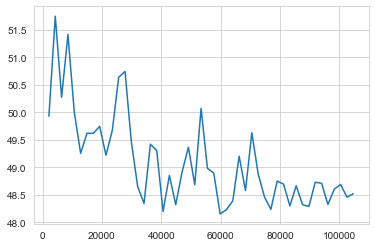

In [52]:
history_df[history_df['eval/loss'].notna()]['eval/loss'].plot()

<AxesSubplot:>

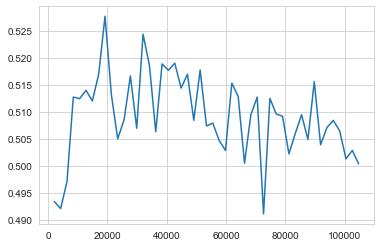

In [62]:
history_df[history_df['eval/loss'].notna()]['eval/ndcg@1_g.exponential_d.logarithmic'].plot()

In [122]:
history_df['train/loss_gaussian'] = gaussian_filter1d(history_df['train/loss'], sigma=100)

<AxesSubplot:>

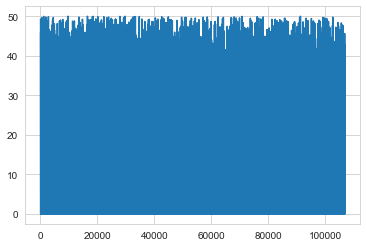

In [123]:
history_df[history_df['train/loss'] <= 50]['train/loss'].plot()

<AxesSubplot:>

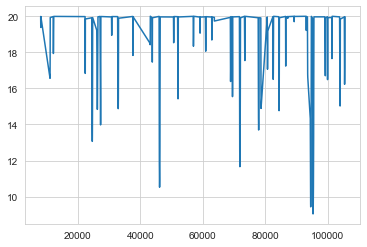

In [124]:
history_df[history_df['train/loss_gaussian'] <= 20]['train/loss_gaussian'].plot()